In [1]:
%matplotlib inline

from sklearn.model_selection import train_test_split

import matplotlib.pyplot as plt
import nengo
from nengo.utils.filter_design import cont2discrete
import numpy as np
import tensorflow as tf
from dv import LegacyAedatFile
from skimage.transform import resize

import nengo_dl

from IPython.display import clear_output

## Gesture Dataset Environment

In [14]:
def load_gesture(name, gesture):
    with open("../DVS_Gesture_Dataset/DvsGesture/"+name[:-7]+"_labels.csv", "r") as l:
        for line in l:
            labels = line.split(",")
            if labels[0] == str(gesture):
                start = int(labels[1])
                end = int(labels[2])
    
    events = []
    with LegacyAedatFile("../DVS_Gesture_Dataset/DvsGesture/"+name[:-1]) as f:
        for event in f:
            if event.timestamp >= start and event.timestamp <= end:
                events.append([event.x/128, event.y/128])
    return np.array(events)

def load_img_gesture(name, gesture):
    with open("../DVS_Gesture_Dataset/DvsGesture/"+name[:-7]+"_labels.csv", "r") as l:
        for line in l:
            labels = line.split(",")
            if labels[0] == str(gesture):
                start = int(labels[1])
                end = int(labels[2])
    
    events = []
    bin_events = np.zeros((128, 128))
    prev_time = start
    cumu_time = 0
    with LegacyAedatFile("../DVS_Gesture_Dataset/DvsGesture/"+name[:-1]) as f:
        for event in f:
            if event.timestamp >= start and event.timestamp <= end:
                bin_events[event.x, event.y] = 1
                
                cumu_time += event.timestamp - prev_time
                prev_time = event.timestamp
                if cumu_time >= 100000: # bin of 100ms
                    cumu_time = 0
                    events = np.hstack([events, resize(bin_events, (32, 32), anti_aliasing=False).flatten()])
                    bin_events = np.zeros((128, 128))
    return trim_gesture(events, 40960)

def trim_gesture(gesture, gesture_size):
    if gesture.shape[0] > gesture_size:
        gesture = gesture[0:gesture_size]
    else:
        temp = np.zeros(gesture_size, 3)
        temp[:gesture.shape[0]] = gesture
        gesture = temp
    return gesture

gestures = []
labels = []
count = 1
with open("../DVS_Gesture_Dataset/DvsGesture/trials_to_train.txt") as file:
    for name in file:
        for label in range(0, 2):
            try:
                gestures.append(load_img_gesture(name, label+1))
                labels.append(label)
                
                print("loaded", name[:-1], count)
                count += 1
            except:
                print("failed to load", name[:-1])

gestures = np.array(gestures)
gestures = gestures[:, :, np.newaxis]
temp = np.zeros((len(labels), 1, 1))
temp[:, 0, 0] = np.array(labels)
labels = temp

(51200,)
loaded user01_fluorescent.aedat 1
(58368,)
loaded user01_fluorescent.aedat 2
(51200,)
loaded user01_fluorescent_led.aedat 3
(62464,)
loaded user01_fluorescent_led.aedat 4
(50176,)
loaded user01_lab.aedat 5
(45056,)
loaded user01_lab.aedat 6
(48128,)
loaded user01_led.aedat 7
(67584,)
loaded user01_led.aedat 8
(65536,)
loaded user01_natural.aedat 9
(90112,)
loaded user01_natural.aedat 10
(58368,)
loaded user02_fluorescent.aedat 11
(68608,)
loaded user02_fluorescent.aedat 12
(46080,)
loaded user02_fluorescent_led.aedat 13
(56320,)
loaded user02_fluorescent_led.aedat 14
failed to load user02_lab.aedat

loaded user02_lab.aedat 15
(57344,)
loaded user02_lab.aedat 16
(45056,)
loaded user02_led.aedat 17
(58368,)
loaded user02_led.aedat 18
(67584,)
loaded user02_natural.aedat 19
(75776,)
loaded user02_natural.aedat 20
(56320,)
loaded user03_fluorescent.aedat 21
(66560,)
loaded user03_fluorescent.aedat 22
(60416,)
loaded user03_fluorescent_led.aedat 23
(65536,)
loaded user03_fluorescen

(43008,)
loaded user22_led.aedat 186
(55296,)
loaded user22_natural.aedat 187
(74752,)
loaded user22_natural.aedat 188
(67584,)
loaded user23_fluorescent.aedat 189
(73728,)
loaded user23_fluorescent.aedat 190
(50176,)
loaded user23_fluorescent_led.aedat 191
(59392,)
loaded user23_fluorescent_led.aedat 192
(54272,)
loaded user23_lab.aedat 193
(68608,)
loaded user23_lab.aedat 194
(67584,)
loaded user23_led.aedat 195
(64512,)
loaded user23_led.aedat 196
(46080,)
loaded user24_fluorescent.aedat 197
(60416,)
loaded user24_fluorescent.aedat 198
(41984,)
loaded user24_fluorescent_led.aedat 199
(60416,)
loaded user24_fluorescent_led.aedat 200
(50176,)
loaded user24_led.aedat 201
(57344,)
loaded user24_led.aedat 202
(55296,)
loaded user25_fluorescent.aedat 203
(65536,)
loaded user25_fluorescent.aedat 204
(48128,)
loaded user25_led.aedat 205
(53248,)
loaded user25_led.aedat 206
(50176,)
loaded user26_fluorescent.aedat 207
(68608,)
loaded user26_fluorescent.aedat 208
(62464,)
loaded user26_fluore

In [16]:
np.save("gestures_img_2", gestures)
np.save("labels_img_2", labels)

In [2]:
gestures = np.load("gestures.npy")
labels = np.load("labels.npy")

In [15]:
gestures.shape

(228, 40960, 1)

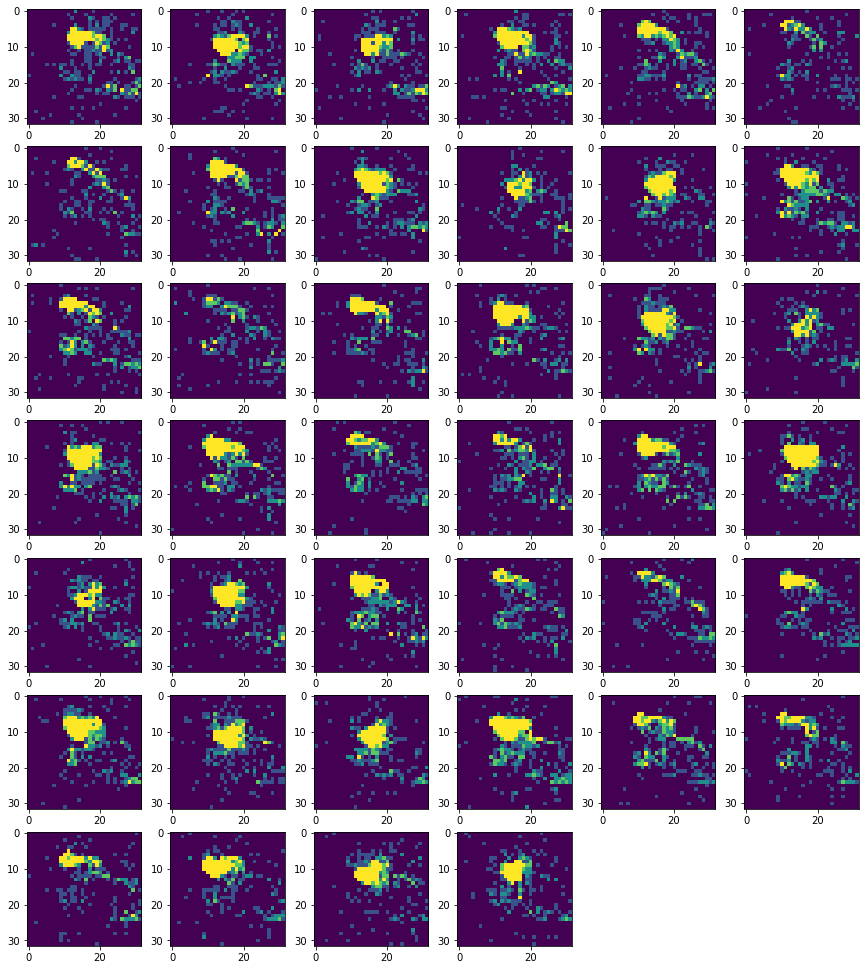

In [20]:
plt.figure(figsize=(15, 50))
nb_img = 40
for i in range(nb_img):
    plt.subplot(20, 6, i+1)
    plt.imshow(gestures[3].reshape((40, 1024))[i].reshape(32, 32))

## Legendre Memory Unit Cell Definition

In [21]:
class LMUCell(nengo.Network):
    def __init__(self, units, order, theta, input_d, **kwargs):
        super().__init__(**kwargs)

        # compute the A and B matrices according to the LMU's mathematical derivation
        # (see the paper for details)
        Q = np.arange(order, dtype=np.float64)
        R = (2 * Q + 1)[:, None] / theta
        j, i = np.meshgrid(Q, Q)

        A = np.where(i < j, -1, (-1.0) ** (i - j + 1)) * R
        B = (-1.0) ** Q[:, None] * R
        C = np.ones((1, order))
        D = np.zeros((1,))

        A, B, _, _, _ = cont2discrete((A, B, C, D), dt=1.0, method="zoh")

        with self:
            nengo_dl.configure_settings(trainable=None)

            # create objects corresponding to the x/u/m/h variables in the above diagram
            self.x = nengo.Node(size_in=input_d)
            self.u = nengo.Node(size_in=1)
            self.m = nengo.Node(size_in=order)
            self.h = nengo_dl.TensorNode(tf.nn.tanh, shape_in=(units,), pass_time=False)

            # compute u_t from the above diagram.
            # note that setting synapse=0 (versus synapse=None) adds a one-timestep
            # delay, so we can think of any connections with synapse=0 as representing
            # value_{t-1}
            nengo.Connection(
                self.x, self.u, transform=np.ones((1, input_d)), synapse=None
            )
            nengo.Connection(self.h, self.u, transform=np.zeros((1, units)), synapse=0)
            nengo.Connection(self.m, self.u, transform=np.zeros((1, order)), synapse=0)

            # compute m_t
            # in this implementation we'll make A and B non-trainable, but they
            # could also be optimized in the same way as the other parameters
            conn_A = nengo.Connection(self.m, self.m, transform=A, synapse=0)
            self.config[conn_A].trainable = False
            conn_B = nengo.Connection(self.u, self.m, transform=B, synapse=None)
            self.config[conn_B].trainable = False

            # compute h_t
            nengo.Connection(
                self.x, self.h, transform=np.zeros((units, input_d)), synapse=None
            )
            nengo.Connection(
                self.h, self.h, transform=np.zeros((units, units)), synapse=0
            )
            nengo.Connection(
                self.m,
                self.h,
                transform=nengo_dl.dists.Glorot(distribution="normal"),
                synapse=None,
            )

## Network Definition

In [22]:
tau_slow = 0.01
tau_fast = None
discount = 0.95

with nengo.Network() as net:
    nengo_dl.configure_settings(
        trainable=None,
        stateful=False,
        keep_history=False,
    )
    
    # input node
    inp = nengo.Node(np.zeros(gestures.shape[-1]))
    
    # LMU cell
    lmu = LMUCell(
        units=212,
        order=256,
        theta=gestures.shape[1], # number of events per gesture
        input_d=gestures.shape[-1], # number of dimension per event (3)
    )
    conn = nengo.Connection(inp, lmu.x, synapse=None)
    net.config[conn].trainable = False
    
    # dense linear readout
    out = nengo.Node(size_in=2)
    nengo.Connection(lmu.h, out, transform=nengo_dl.dists.Glorot(), synapse=None)

    # record output. note that we set keep_history=False above, so this will
    # only record the output on the last timestep (which is all we need
    # on this task)
    p = nengo.Probe(out)

In [23]:
X_train, X_test, y_train, y_test = train_test_split(gestures, labels, test_size=0.33, random_state=42)

In [24]:
with nengo_dl.Simulator(net, minibatch_size=8, unroll_simulation=8) as sim:
    sim.compile(
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.optimizers.Adam(),
        metrics=["accuracy"],
    )

    sim.fit(X_train, y_train, epochs=2)
    sim.save_params("./lmu_params")

    print(
        "Final test accuracy: %.2f%%"
        % (sim.evaluate(X_test, y_test, verbose=0)["probe_accuracy"] * 100)
    )

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
|############Constructing graph: pre-build stage (58%)           | ETA: 0:00:00

/home/thomas/anaconda3/envs/rl-snn/lib/python3.8/site-packages/nengo_dl/simulator.py:466: UserWarning: No GPU support detected. See https://www.nengo.ai/nengo-dl/installation.html#installing-tensorflow for instructions on setting up TensorFlow with GPU support.
  warnings.warn(


Construction finished in 0:00:00                                               
Epoch 1/2
19/19 [==============================] - 3250s 171s/step - loss: 0.2714 - probe_loss: 0.2714 - probe_accuracy: 0.9408
Epoch 2/2


KeyboardInterrupt: 

In [25]:
with nengo_dl.Simulator(net, minibatch_size=8, unroll_simulation=8) as sim:
    sim.compile(
        loss=tf.losses.SparseCategoricalCrossentropy(from_logits=True),
        optimizer=tf.optimizers.Adam(),
        metrics=["accuracy"],
    )

    #sim.fit(X_train, y_train, epochs=1)
    sim.save_params("./lmu_params")
    

Build finished in 0:00:00                                                      
Optimization finished in 0:00:00                                               
Construction finished in 0:00:00                                               
